In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


100%|██████████| 170498071/170498071 [00:04<00:00, 36531793.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


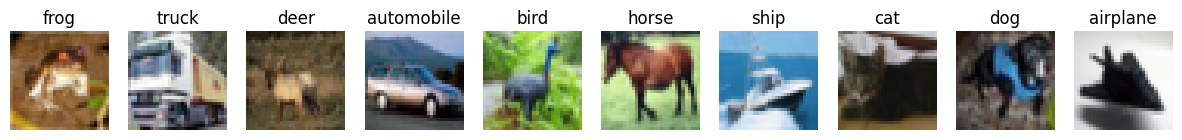

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

def show_random_images(dataset):
    class_images = {}
    for image, label in dataset:
        if label not in class_images:
            class_images[label] = image
        if len(class_images) == 10:
            break
    
    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    classes = dataset.classes  # Get class names
    for i, (label, image) in enumerate(class_images.items()):
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy().transpose((1, 2, 0))
        axes[i].imshow(np_image)
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

show_random_images(train_dataset)

In [5]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [6]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch 1/30, Train Loss: 1.4680, Train Acc: 48.30%, Val Loss: 1.2362, Val Acc: 57.66%
Epoch 2/30, Train Loss: 1.1648, Train Acc: 59.84%, Val Loss: 1.1293, Val Acc: 61.19%
Epoch 3/30, Train Loss: 1.0612, Train Acc: 63.77%, Val Loss: 1.1396, Val Acc: 61.75%
Epoch 4/30, Train Loss: 1.0069, Train Acc: 65.72%, Val Loss: 1.1062, Val Acc: 62.68%
Epoch 5/30, Train Loss: 0.9547, Train Acc: 67.69%, Val Loss: 1.1133, Val Acc: 62.98%
Epoch 6/30, Train Loss: 0.9101, Train Acc: 69.06%, Val Loss: 1.1061, Val Acc: 63.59%
Epoch 7/30, Train Loss: 0.8740, Train Acc: 70.16%, Val Loss: 1.1448, Val Acc: 62.45%
Epoch 8/30, Train Loss: 0.8427, Train Acc: 71.28%, Val Loss: 1.1742, Val Acc: 61.46%
Epoch 9/30, Train Loss: 0.8045, Train Acc: 72.45%, Val Loss: 1.1642, Val Acc: 62.98%
Epoch 10/30, Train Loss: 0.7782, Train Acc: 73.48%, Val Loss: 1.2683, Val Acc: 61.05%
Epoch 11/30, Train Loss: 0.7484, Train Acc: 74.43%, Val Loss: 1.2273, Val Acc: 61.46%
Epoch 12/30, Train Loss: 0.7261, Train Acc: 74.92%, Val Loss: 1

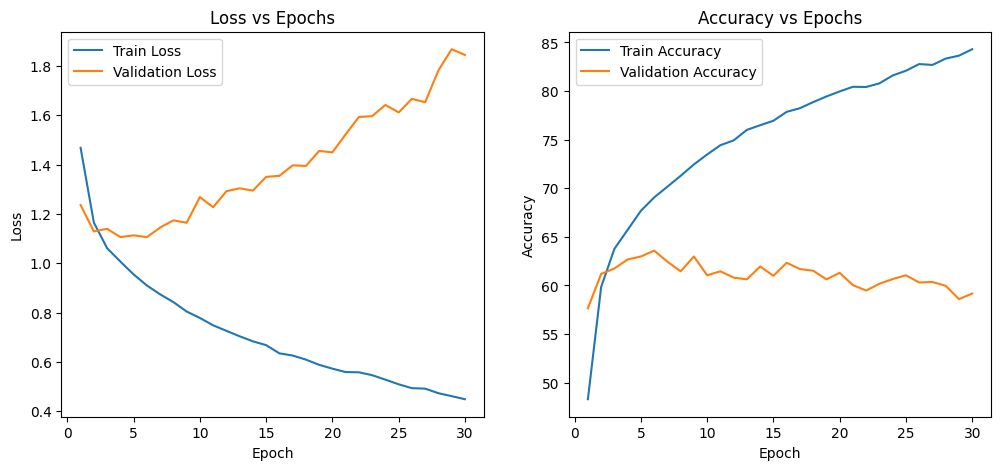

Best model saved as 'best_model.pth'


In [9]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30
best_val_accuracy = 0
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [] , []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

print("Best model saved as 'best_model.pth'")

In [7]:
class UpgradedModel(nn.Module):
    def __init__(self):
        super(UpgradedModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 1
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # Pooling Layer 2
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Conv Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),          # Pooling Layer 3
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Conv Layer 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)           # Pooling Layer 4
        )
        
        # Dynamically calculate the flattened size
        self.flatten_size = self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),  # FC Layer 1
            nn.ReLU(),
            nn.Linear(256, 128),                # FC Layer 2
            nn.ReLU(),
            nn.Linear(128, 10)                  # FC Layer 3
        )

    def _get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, 32, 32)  
        x = self.conv_layers(dummy_input)
        return x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x

Epoch 1/30, Train Loss: 1.5368, Train Acc: 42.84%, Val Loss: 1.2263, Val Acc: 55.97%
Epoch 2/30, Train Loss: 1.0453, Train Acc: 62.41%, Val Loss: 0.9035, Val Acc: 68.31%
Epoch 3/30, Train Loss: 0.7830, Train Acc: 72.71%, Val Loss: 0.8185, Val Acc: 71.44%
Epoch 4/30, Train Loss: 0.5944, Train Acc: 79.37%, Val Loss: 0.7240, Val Acc: 75.08%
Epoch 5/30, Train Loss: 0.4484, Train Acc: 84.44%, Val Loss: 0.7592, Val Acc: 75.55%
Epoch 6/30, Train Loss: 0.3249, Train Acc: 88.53%, Val Loss: 0.7940, Val Acc: 75.79%
Epoch 7/30, Train Loss: 0.2301, Train Acc: 92.05%, Val Loss: 0.9111, Val Acc: 76.34%
Epoch 8/30, Train Loss: 0.1634, Train Acc: 94.42%, Val Loss: 0.9868, Val Acc: 75.59%
Epoch 9/30, Train Loss: 0.1392, Train Acc: 95.19%, Val Loss: 1.1019, Val Acc: 74.03%
Epoch 10/30, Train Loss: 0.1213, Train Acc: 95.89%, Val Loss: 1.2110, Val Acc: 74.20%
Epoch 11/30, Train Loss: 0.1012, Train Acc: 96.65%, Val Loss: 1.2279, Val Acc: 74.23%
Epoch 12/30, Train Loss: 0.0945, Train Acc: 96.85%, Val Loss: 1

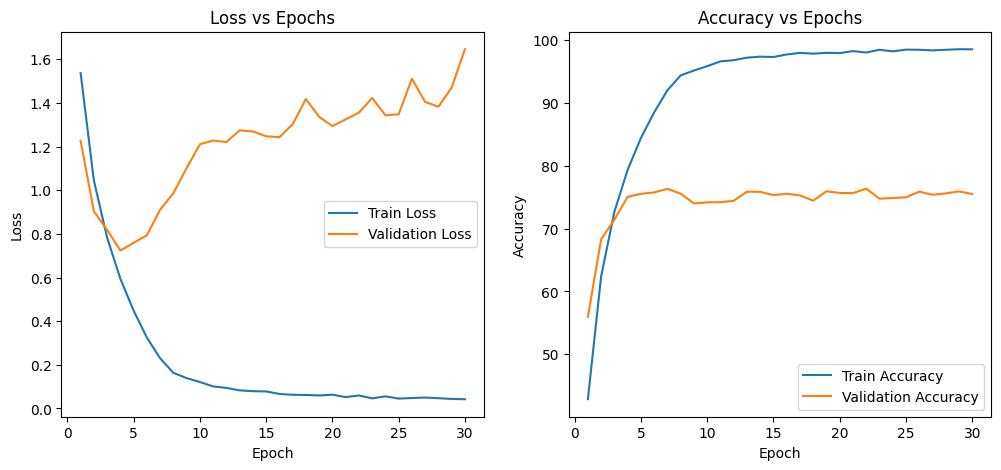

Best upgraded model saved as 'upgraded_best_model.pth'


In [14]:
model = UpgradedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
best_val_accuracy = 0
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [] , []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "upgraded_best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

print("Best upgraded model saved as 'upgraded_best_model.pth'")

The UpgradedModel outperforms the BaselineModel in both accuracy and generalization due to its deeper architecture and higher feature extraction capability. However, it is more computationally intensive. The BaselineModel is simpler and less effective, suitable for scenarios prioritizing computational efficiency over accuracy. The BaselineModel also shows signs of overfitting, with a large gap between training and validation accuracy, while the UpgradedModel maintains a more stable and consistent performance across both training and validation.

In [8]:
class UpgradedModelWithBN(nn.Module):
    def __init__(self):
        super(UpgradedModelWithBN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv Layer 1
            nn.BatchNorm2d(64),                         # BN Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 1
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer 2
            nn.BatchNorm2d(128),                          # BN Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # Pooling Layer 2
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Conv Layer 3
            nn.BatchNorm2d(256),                           # BN Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),          # Pooling Layer 3
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Conv Layer 4
            nn.BatchNorm2d(512),                           # BN Layer 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)           # Pooling Layer 4
        )
        
        self.flatten_size = self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),  # FC Layer 1
            nn.ReLU(),
            nn.Linear(256, 128),                # FC Layer 2
            nn.ReLU(),
            nn.Linear(128, 10)                  # FC Layer 3
        )

    def _get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, 32, 32)  
        x = self.conv_layers(dummy_input)
        return x.numel()  

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x


Epoch 1/30, Train Loss: 1.2474, Train Acc: 54.55%, Val Loss: 1.0591, Val Acc: 63.14%
Epoch 2/30, Train Loss: 0.8224, Train Acc: 71.12%, Val Loss: 0.8965, Val Acc: 69.10%
Epoch 3/30, Train Loss: 0.6498, Train Acc: 77.07%, Val Loss: 0.7382, Val Acc: 75.15%
Epoch 4/30, Train Loss: 0.5183, Train Acc: 81.92%, Val Loss: 0.6612, Val Acc: 77.25%
Epoch 5/30, Train Loss: 0.4094, Train Acc: 85.70%, Val Loss: 0.9220, Val Acc: 73.78%
Epoch 6/30, Train Loss: 0.3121, Train Acc: 89.06%, Val Loss: 0.6660, Val Acc: 79.22%
Epoch 7/30, Train Loss: 0.2312, Train Acc: 91.91%, Val Loss: 0.6578, Val Acc: 79.81%
Epoch 8/30, Train Loss: 0.1842, Train Acc: 93.55%, Val Loss: 0.7396, Val Acc: 79.70%
Epoch 9/30, Train Loss: 0.1416, Train Acc: 95.02%, Val Loss: 0.7574, Val Acc: 80.54%
Epoch 10/30, Train Loss: 0.1100, Train Acc: 96.14%, Val Loss: 0.9636, Val Acc: 79.07%
Epoch 11/30, Train Loss: 0.0888, Train Acc: 96.98%, Val Loss: 0.9142, Val Acc: 79.79%
Epoch 12/30, Train Loss: 0.0829, Train Acc: 97.19%, Val Loss: 0

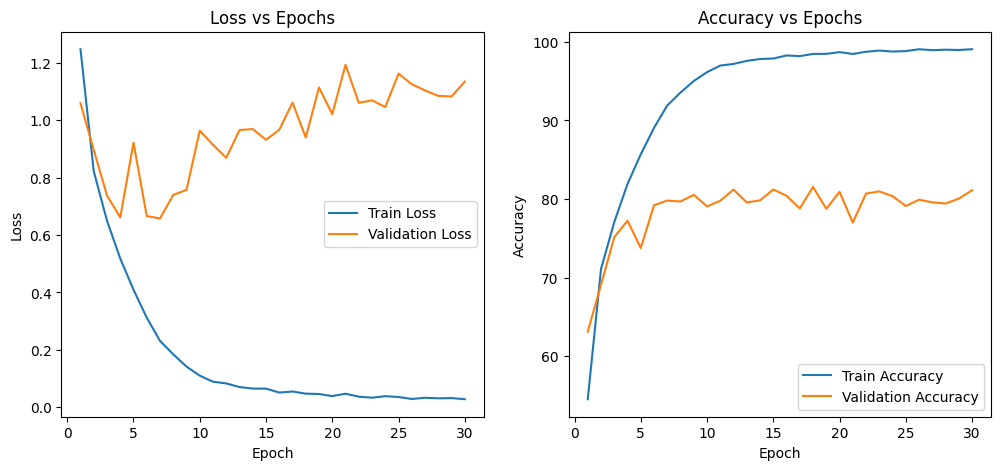

Best upgraded model saved as 'upgraded_best_model_BN.pth'


In [16]:
model = UpgradedModelWithBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
best_val_accuracy = 0
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [] , []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "upgraded_best_model_BN.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

print("Best upgraded model saved as 'upgraded_best_model_BN.pth'")

The UpgradedModelWithBN improves on the original UpgradedModel by incorporating Batch Normalization (BN), which helps stabilize training and potentially accelerate convergence. The model achieves higher validation accuracy and smoother training, with more consistent performance across epochs. In particular, the inclusion of BN reduces overfitting by normalizing activations, helping to maintain a better balance between training and validation performance.

The UpgradedModelWithBN shows less fluctuation in validation accuracy compared to the UpgradedModel, which had a noticeable drop in performance during later epochs. Overall, UpgradedModelWithBN provides better generalization, maintaining higher accuracy on the validation set throughout training, while still being computationally more intensive than the simpler BaselineModel.

In [9]:
class UpgradedModelWithBNAndDropout(nn.Module):
    def __init__(self):
        super(UpgradedModelWithBNAndDropout, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv Layer 1
            nn.BatchNorm2d(64),                         # BN Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Pooling Layer 1
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv Layer 2
            nn.BatchNorm2d(128),                          # BN Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),         # Pooling Layer 2
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Conv Layer 3
            nn.BatchNorm2d(256),                           # BN Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),          # Pooling Layer 3
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Conv Layer 4
            nn.BatchNorm2d(512),                           # BN Layer 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)           # Pooling Layer 4
        )
        
        self.flatten_size = self._get_flatten_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),  # FC Layer 1
            nn.ReLU(),
            nn.Dropout(0.1),                    # Dropout Layer 1
            nn.Linear(256, 128),                # FC Layer 2
            nn.ReLU(),
            nn.Dropout(0.1),                    # Dropout Layer 2
            nn.Linear(128, 10)                  # FC Layer 3
        )

    def _get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, 32, 32)  
        x = self.conv_layers(dummy_input)
        return x.numel()  

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten for FC layers
        x = self.fc_layers(x)
        return x

Epoch 1/30, Train Loss: 1.3062, Train Acc: 52.23%, Val Loss: 1.0083, Val Acc: 63.25%
Epoch 2/30, Train Loss: 0.8750, Train Acc: 69.31%, Val Loss: 0.8331, Val Acc: 70.75%
Epoch 3/30, Train Loss: 0.6982, Train Acc: 75.95%, Val Loss: 0.7312, Val Acc: 74.72%
Epoch 4/30, Train Loss: 0.5762, Train Acc: 80.28%, Val Loss: 0.6879, Val Acc: 76.31%
Epoch 5/30, Train Loss: 0.4627, Train Acc: 83.94%, Val Loss: 0.7104, Val Acc: 76.84%
Epoch 6/30, Train Loss: 0.3776, Train Acc: 86.95%, Val Loss: 0.7058, Val Acc: 77.76%
Epoch 7/30, Train Loss: 0.3023, Train Acc: 89.65%, Val Loss: 0.7256, Val Acc: 79.04%
Epoch 8/30, Train Loss: 0.2285, Train Acc: 92.22%, Val Loss: 0.8080, Val Acc: 78.63%
Epoch 9/30, Train Loss: 0.1863, Train Acc: 93.69%, Val Loss: 0.7288, Val Acc: 80.19%
Epoch 10/30, Train Loss: 0.1462, Train Acc: 95.08%, Val Loss: 0.8409, Val Acc: 79.06%
Epoch 11/30, Train Loss: 0.1250, Train Acc: 95.70%, Val Loss: 0.8123, Val Acc: 80.93%
Epoch 12/30, Train Loss: 0.1009, Train Acc: 96.61%, Val Loss: 0

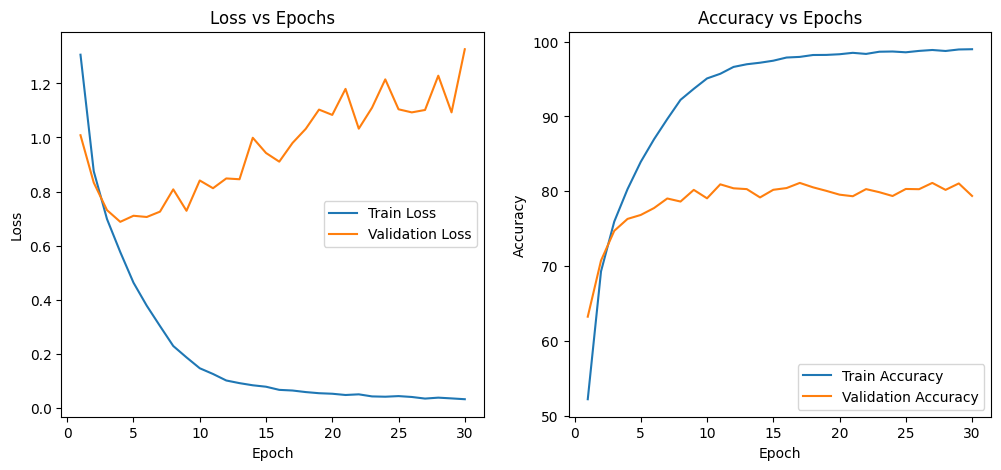

Best upgraded model saved as 'upgraded_best_model_BN_DO.pth'


In [32]:
model = UpgradedModelWithBNAndDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
best_val_accuracy = 0
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [] , []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "upgraded_best_model_BN_DO.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

print("Best upgraded model saved as 'upgraded_best_model_BN_DO.pth'")

The UpgradedModelWithBNAndDropout improves upon the UpgradedModelWithBN by incorporating dropout, which helps mitigate overfitting and enhances generalization. While the UpgradedModelWithBN showed early high performance followed by overfitting (declining validation accuracy), the UpgradedModelWithBNAndDropout maintains more consistent validation accuracy throughout training. The dropout layer introduces regularization, leading to better generalization with only a slight trade-off in training accuracy. Overall, UpgradedModelWithBNAndDropout offers more robust performance, especially in preventing overfitting compared to the UpgradedModelWithBN.

Evaluating Baseline Model...


/tmp/ipykernel_23/2352073018.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


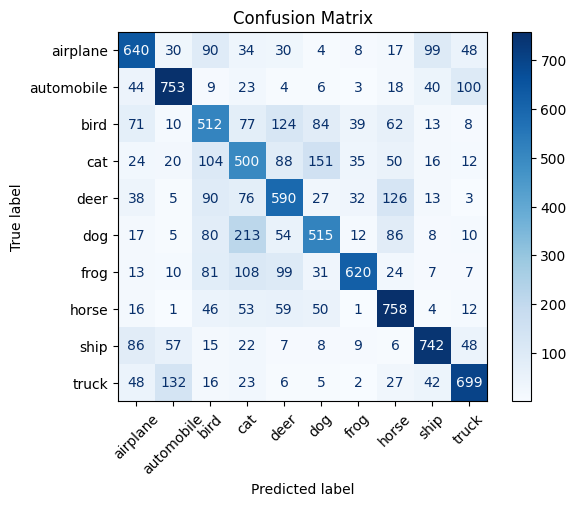

Test Accuracy for Baseline Model: 63.29%
Evaluating Upgraded Model...


/tmp/ipykernel_23/2352073018.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


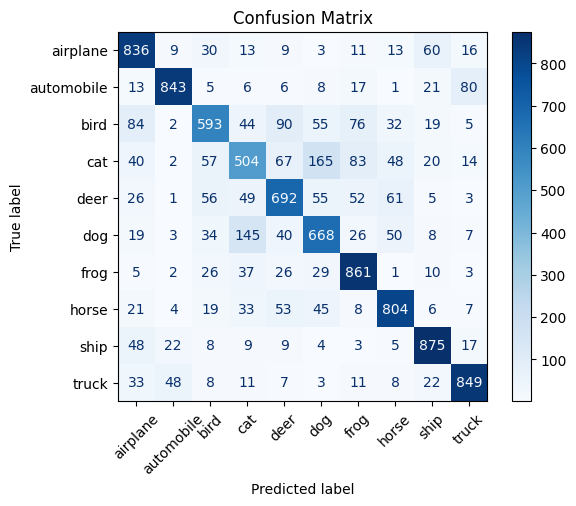

Test Accuracy for Upgraded Model: 75.25%
Evaluating BN Model...


/tmp/ipykernel_23/2352073018.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


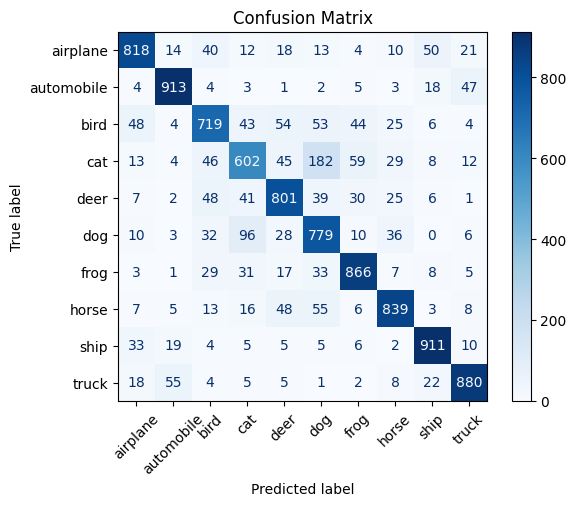

Test Accuracy for BN Model: 81.28%
Evaluating BN + Dropout Model...


/tmp/ipykernel_23/2352073018.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


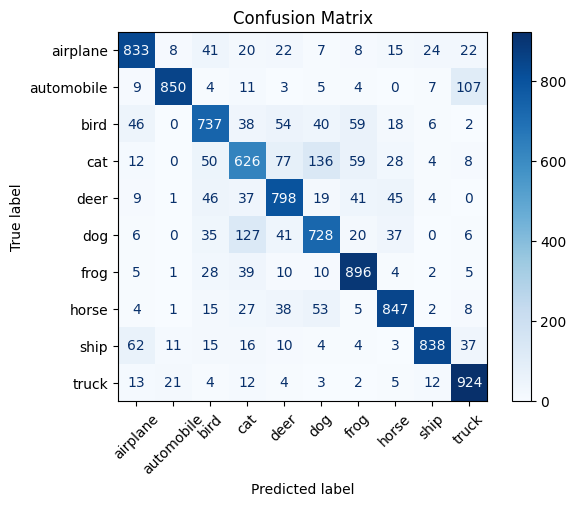

Test Accuracy for BN + Dropout Model: 84.37%

Test Accuracy Results:
Baseline Model: 63.29%
Upgraded Model: 75.25%
BN Model: 81.28%
BN + Dropout Model: 84.37%


In [15]:
def load_model(model_path, model_class):
    model = model_class()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

def evaluate_model(model, test_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes).plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix")
    plt.show()
    
    return accuracy

models = {
    "Baseline Model": ("best_model.pth", BaselineModel),  # Replace with the correct class if different
    "Upgraded Model": ("upgraded_best_model.pth", UpgradedModel),
    "BN Model": ("upgraded_best_model_BN.pth", UpgradedModelWithBN),
    "BN + Dropout Model": ("upgraded_best_model_BN_DO.pth", UpgradedModelWithBNAndDropout),
}

# Evaluate each model
results = {}
for model_name, (model_path, model_class) in models.items():
    print(f"Evaluating {model_name}...")
    model = load_model(model_path, model_class)
    accuracy = evaluate_model(model, test_loader)
    results[model_name] = accuracy
    print(f"Test Accuracy for {model_name}: {accuracy:.2f}%")

# Display all results
print("\nTest Accuracy Results:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.2f}%")

The Baseline Model achieves a test accuracy of 63.29% but struggles to generalize due to its simple architecture, which lacks the capacity to extract deep features. As a result, it performs poorly on complex classes like cat, bird, and truck, with significant confusion between visually similar categories such as truck and automobile or ship and airplane.

The Upgraded Model improves accuracy to 75.25% by using a deeper architecture with multiple convolutional layers. This enhances feature extraction and reduces misclassifications, particularly for classes like airplane and truck. However, errors persist in visually similar classes such as cat and dog, and overfitting still occurs despite the improvements.

With the addition of Batch Normalization, the test accuracy rises to 81.28%. BN stabilizes training, accelerates convergence, and reduces internal covariate shift, leading to better generalization. Misclassifications decrease significantly in classes like dog, deer, and ship, as BN allows for smoother gradient flow and improved learning of feature representations.

The BN + Dropout Model achieves the highest test accuracy of 84.37% by combining Batch Normalization with Dropout. Dropout mitigates overfitting by randomly deactivating neurons, preventing the model from relying on specific features. This results in more robust generalization and fewer errors across all classes, particularly for challenging ones like cat, bird, and truck. Overall, the combination of deeper architecture, BN, and Dropout progressively improves performance by enhancing feature learning, stabilizing training, and reducing overfitting.